# PASA Proyecto 1

Eliminación de ruido de EOG y EMG

# Preparación del Entorno

- Instalación de librerías
- Descarga de Dataset

In [1]:
# Para instalar en el entorno la librería para RW de archivos .edf
!pip install pyedflib
!pip install padasip

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 2.4 MB 27.0 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Created wheel for padasip: filename=padasip-1.2.2-py3-none-any.whl size=51671 sha256=0f3a5f568eeec7571a7fd3c70cf9344a1e571fddc4292ffbaa7eede97d1cdcee
  Stored in directory: /root/.cache/pip/wheels/c4/01/bb/57bde54bdefd572205aebfaefeedcc0c5d0ca6a6aa01db0858
Successfully built padasip


In [259]:
# Usar este comando cambiando el final del link para descargar archivos individuales
# El database completo pesa 40.1 GB y va a estar todo el día
!wget -r -N -c -np https://physionet.org/files/hmc-sleep-staging/1.1/recordings/SN001.edf

--2022-10-29 17:36:15--  https://physionet.org/files/hmc-sleep-staging/1.1/recordings/SN001.edf
Resolving physionet.org (physionet.org)... 18.18.42.54
Connecting to physionet.org (physionet.org)|18.18.42.54|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 105064704 (100M) [application/octet-stream]
Saving to: ‘physionet.org/files/hmc-sleep-staging/1.1/recordings/SN001.edf’

physionet.org/files 100%[===================>] 100.20M  7.66MB/s    in 12s     

2022-10-29 17:36:28 (8.03 MB/s) - ‘physionet.org/files/hmc-sleep-staging/1.1/recordings/SN001.edf’ saved [105064704/105064704]

FINISHED --2022-10-29 17:36:28--
Total wall clock time: 13s
Downloaded: 1 files, 100M in 12s (8.03 MB/s)


# Carga de Datos

- Extracción de información del dataset
- Extracción de canales a analizar


In [283]:
from pyedflib import highlevel
signals, signal_headers, header = highlevel.read_edf('/content/physionet.org/files/hmc-sleep-staging/1.1/recordings/SN008.edf')

## Información sobre el Dataset

In [284]:
print('Lista de Canales en esta base de datos: \n')
for sh in signal_headers:
  print(sh['label'], '  \t' ,sh['prefilter'],'  \tSample Rate:',sh['sample_rate'])

Lista de Canales en esta base de datos: 

EEG F4-M1   	 HP:0.2Hz LP:35.0Hz   	Sample Rate: 256.0
EEG C4-M1   	 HP:0.2Hz LP:35.0Hz   	Sample Rate: 256.0
EEG O2-M1   	 HP:0.2Hz LP:35.0Hz   	Sample Rate: 256.0
EEG C3-M2   	 HP:0.2Hz LP:35.0Hz   	Sample Rate: 256.0
EMG chin   	 HP:1.0Hz LP:150.0Hz   	Sample Rate: 256.0
EOG E1-M2   	 HP:0.2Hz LP:35.0Hz   	Sample Rate: 256.0
EOG E2-M2   	 HP:0.2Hz LP:35.0Hz   	Sample Rate: 256.0
ECG   	 HP:1.0Hz LP:150.0Hz   	Sample Rate: 256.0


La CAP Sleep Database es una colección de 108 grabaciones de Polysomniogramas del Sleep Disorders Center de Ospedale Maggiore de Parma, Italia.

Se usarán los siguientes canales para la eliminación de ruido de EEG por EOG o EMG:

- **ROC - LOC** corresponde al canal EOG de medición diferencial entre los transductores oculares derechos e izquierdos.
- **EMG1-EMG2** corresponde al canal EMG de medición diferencial entre los transductores en el músculo submental (debajo del mentón).
- **X# - Y#** corresponden a canales de EEG X# en referencia a Y#

Se debe notar que el ruido de línea ya está filtrado en esta base de datos

## Carga del Dataset

### Funciones Auxiliares

In [172]:
import padasip as pa
import numpy as np
from scipy import signal
import matplotlib.pyplot as plt

In [173]:
def signal_grab(signals, headers, i):
  '''
  Extract data to be used from the dataset
  '''
  retval = {
      'name': headers[i]['label'],
      'fs': headers[i]['sample_rate'],
      'data': signals[i],
      'units': headers[i]['dimension']
  }
  return retval

def signal_grab_dt(signals, headers, i, dt):
  '''
  Extract data to be used from the dataset
  dt: Time period (s)
  '''
  fs = headers[i]['sample_rate']
  dt = np.array(dt)
  dt = dt * int(fs)
  retval = {
      'name': headers[i]['label'],
      'fs': fs,
      'data': signals[i][dt[0]:dt[1]],
      'units': headers[i]['dimension']
  }
  return retval

In [174]:
def signal_plot(series, fig_size=(10,15)):
  figure, axes = plt.subplots(nrows= len(series), figsize=fig_size)
  for i,s in enumerate(series):
    axes[i].plot(s['data'])
    axes[i].set_title(s['name'])
    axes[i].set_ylabel(s['units'])
    axes[i].set_xlim((0,s['data'].size))
  
  axes[-1].set_xlabel('sample')
  plt.tight_layout()
  plt.show()

def signal_plot_N(series, N, fig_size=(10,15)):
  figure, axes = plt.subplots(nrows= len(series), figsize=fig_size)
  for i,s in enumerate(series):
    axes[i].plot(s['data'][:N])
    axes[i].set_title(s['name'])
    axes[i].set_ylabel(s['units'])
    axes[i].set_xlim((0,s['data'].size))

  axes[:-2].set_xticks([])
  axes[-1].set_xlabel('sample')
  plt.show()

In [175]:
def spectrum_plot(series, fig_size=(10,15)):
  figure, axes = plt.subplots(nrows= len(series), figsize=fig_size)
  for i,s in enumerate(series):
    f, psd = signal.welch(s['data'], fs=s['fs'], window='bartlett')
    axes[i].semilogx(f, 10*np.log10(psd))
    axes[i].set_title(s['name'])
    axes[i].set_xlabel('f [Hz]')
    axes[i].set_ylabel('PSD [V**2/Hz]')
    axes[i].set_xlim((1,1000))
    axes[i].set_ylim((1e-3,1e4))
  plt.show()

def spectrum_plot_n0(series, N0, fig_size=(10,15)):
  figure, axes = plt.subplots(nrows= len(series), figsize=fig_size)
  for i,s in enumerate(series):
    f, psd = signal.welch(s['data'], fs=s['fs'], window='bartlett', nfft = N0)
    axes[i].semilogx(f, 10*np.log10(psd))
    axes[i].set_title(s['name'])
    axes[i].set_xlabel('f [Hz]')
    axes[i].set_ylabel('PSD [V**2/Hz]')
    axes[i].set_xlim((1,1000))
    axes[i].set_ylim((1e-3,1e2))
  plt.show()

def spectrum_plot_1(series, N0, title='Espectro de Potencia', fig_size=(10,15)):
  figure = plt.figure(1, fig_size)
  for i,s in enumerate(series):
    f, psd = signal.welch(s['data'], fs=s['fs'], window='bartlett', nfft = N0)
    plt.plot(f, 10*np.log10(psd))
  
  plt.legend([x['name'] for x in series])
  plt.ylabel('PSD [dB]')
  plt.xlabel('f [Hz]')
  plt.title(title)
  plt.xlim((0,128))
  plt.grid()
  plt.show()

## Visualización de señales

In [285]:
EEG = signal_grab(signals, signal_headers, 3)
EOG = signal_grab(signals, signal_headers, 5)
EMG = signal_grab(signals, signal_headers, 4)

In [288]:
dt = (10,20)
EEG = signal_grab_dt(signals, signal_headers, 3, dt)
EOG = signal_grab_dt(signals, signal_headers, 5, dt)
EMG = signal_grab_dt(signals, signal_headers, 4, dt)

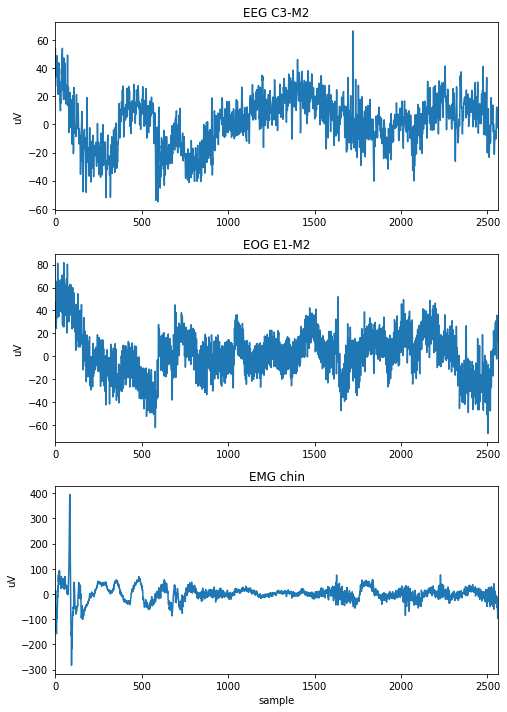

In [289]:
signal_plot([EEG, EOG, EMG], fig_size=(7.16,10))

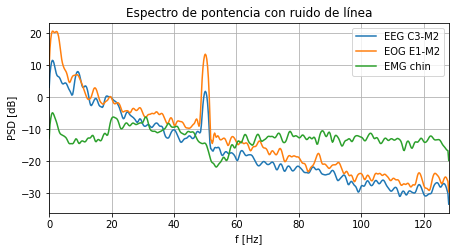

In [265]:
N0 = 1024
#spectrum_plot_n0([EEG, EOG, EMG], N0, fig_size=(20,15))
spectrum_plot_1([EEG, EOG, EMG], N0, title='Espectro de pontencia con ruido de línea', fig_size=(7.16,3.5))

In [182]:
def get_power_at_f(series, f, N0):
  freqs, psd = signal.welch(series['data'], fs=series['fs'], nfft=N0)
  i = np.where(freqs == f)
  return psd[i]

In [266]:
f, psd = signal.welch(EEG['data'], fs=EEG['fs'], nfft=N0)
i = np.where(f == 50)
power50Hzorig=psd[i]
print('Power at 50 Hz =', power50Hzorig)

i = np.where(f==1.25)
print('Power at 1.25 Hz=', psd[i])

Power at 50 Hz = [1.35857006]
Power at 1.25 Hz= [12.89572559]


In [267]:
print('Power at 50 Hz =', get_power_at_f(EEG, 50, N0))

print('Power at 1.25 Hz =', get_power_at_f(EEG, 1.25, N0))

Power at 50 Hz = [1.35857006]
Power at 1.25 Hz = [12.89572559]


Se observa ruido de línea presente en 50 Hz

In [268]:
f, psd = signal.welch(EOG['data'], fs=EOG['fs'], nfft=N0)
i = np.where(psd == psd.max())

print('Frequency at max power =', f[i])

Frequency at max power = [1.5]


In [269]:
f, psd = signal.welch(EMG['data'], fs=EMG['fs'], nfft=N0)
i = np.where(psd == psd.max())

print('Frequency at max power =', f[i])

Frequency at max power = [1.25]


# Procesamiento de Datos

In [42]:
import numpy as np
from scipy import signal
import matplotlib.pyplot as plt
import progressbar as pb

## Funciones Auxiliares

In [97]:
def data_tap(x, M):
  '''
  Genera la matriz de taps MxN
  '''
  N = x.size
  x = np.array(x).reshape(N)
  x_M = np.zeros((N,M))
  
  # Zero-padding
  for m in range(M):
    x_M[m:,m] = x[:N-m]

  return x_M

In [98]:
def filter_notch(seriess, f, Q):
  for s in seriess:
    # Design notch filter
    b, a = signal.iirnotch(f, Q, s['fs'])

    # Filter signals
    s['data'] = signal.filtfilt(b, a, s['data'])

  return seriess

## Análisis

### Eliminación de Ruido de Línea en las 3 series

In [270]:
f_notch = 50  # Hz
Q = 40

[EEG, EOG, EMG] = filter_notch([EEG, EOG, EMG], f_notch, Q)

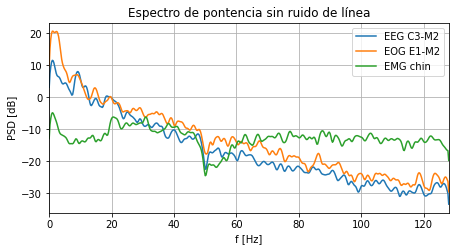

In [271]:
spectrum_plot_1([EEG, EOG, EMG], N0, title='Espectro de pontencia sin ruido de línea', fig_size=(7.16,3.5))

In [272]:
print('Power at 50 Hz =', get_power_at_f(EEG, 50, N0))

print('Power at 1.25 Hz =', get_power_at_f(EEG, 1.25, N0))

Power at 50 Hz = [0.00677428]
Power at 1.25 Hz = [12.89532844]


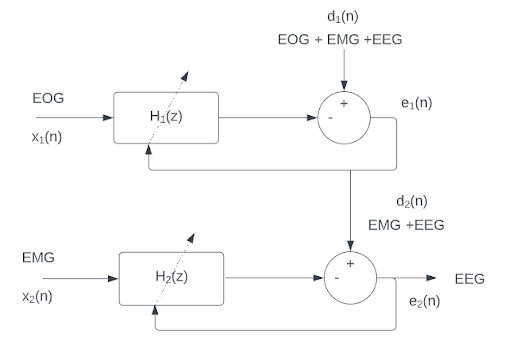

In [273]:
# Primer filtro: x1 = eog, d1 = eeg
M1 = 256
eog_M = data_tap(EOG['data'], M1)   # Reference Data (x)

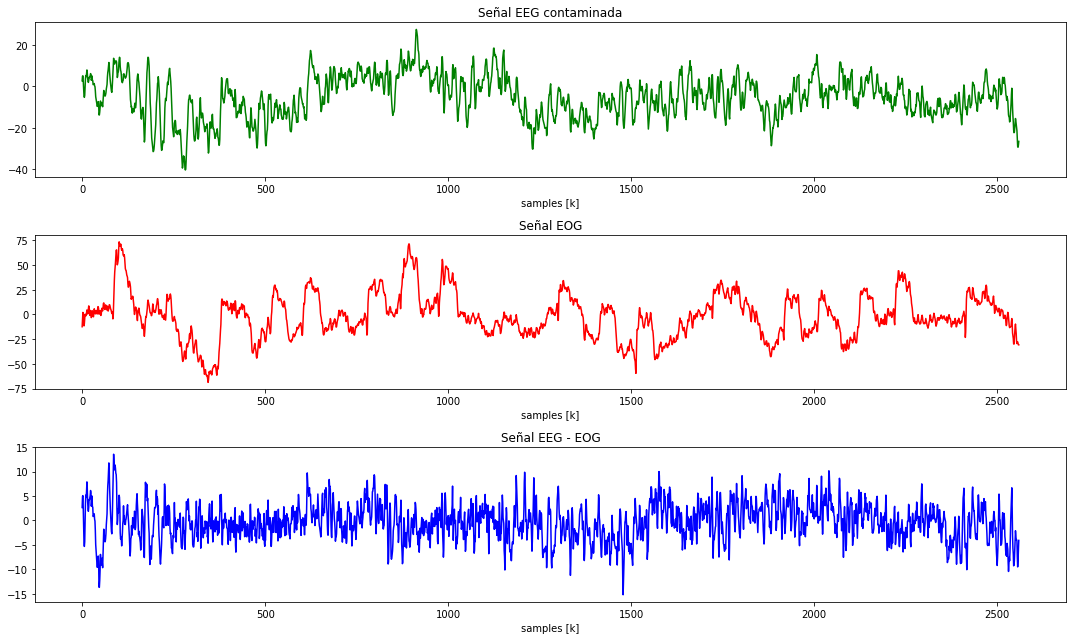

In [274]:
mu1 = 0.000005
f1 = pa.filters.FilterLMS(n = M1, mu=mu1, w='zeros')
y1, e1, w1 = f1.run(EEG['data'],eog_M)

res1 = {
    'name': 'EEG - EOG',
    'fs': EEG['fs'],
    'data': e1,
    'units': EEG['units']
}

plt.figure(figsize=(15,9))
plt.subplot(311)
plt.title("Señal EEG contaminada");plt.xlabel("samples [k]")
plt.plot(EEG['data'],"g", label="eeg")

plt.subplot(312)
plt.title("Señal EOG");plt.xlabel("samples [k]")
plt.plot(EOG['data'],"r", label="eog")

plt.subplot(313)
plt.title("Señal EEG - EOG");plt.xlabel("samples [k]")
plt.plot(e1,"b", label="error")

plt.tight_layout()
plt.show()

In [275]:
print('Power at 50 Hz =', get_power_at_f(res1, 50, N0))
print('Power at 1.25 Hz =', get_power_at_f(res1, 1.25, N0))

Power at 50 Hz = [0.00920423]
Power at 1.25 Hz = [1.06098824]


El EMG tiene una frecuencia de muestreo la mitad que los EEG y EOG, por lo cual se le aplicará un interpolador lineal para tener la cantidad de muestras suficientes para procesarlo.

O, subsampleamos la salida del otro

In [276]:
# Segundo filtro: x2 = emg, d2 = e1 = eeg - eog
M2 = 128
emg_M = data_tap(EMG['data'], M2)

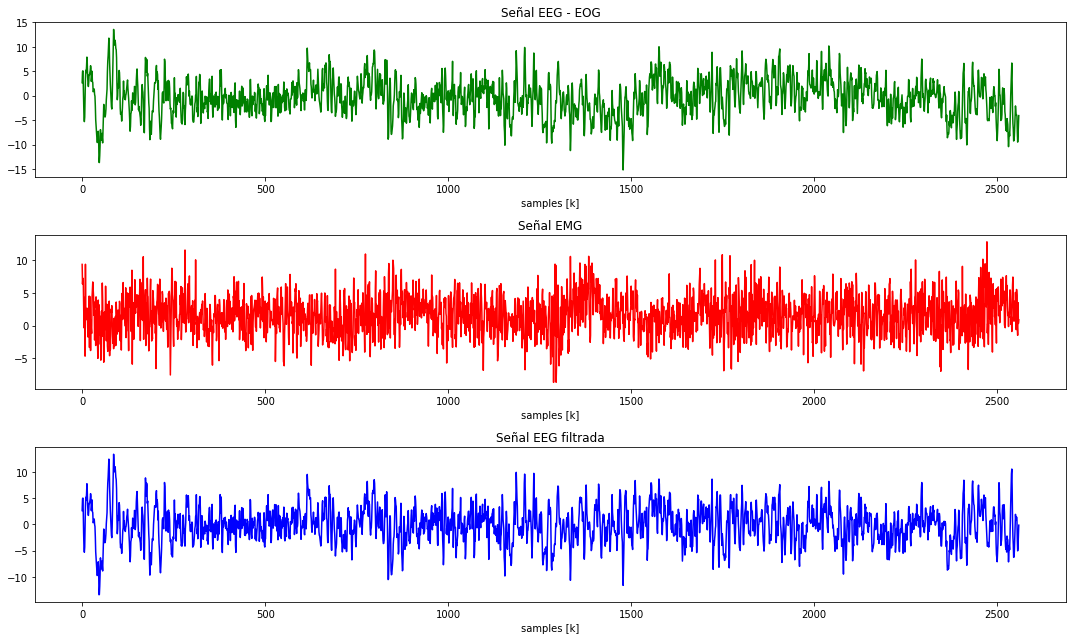

In [277]:
mu2 = 0.00005
f2 = pa.filters.FilterLMS(n = M2, mu=mu2, w='zeros')
y2, e2, w2 = f2.run(e1,emg_M)

res2 = {
    'name': 'EEG - EOG - EMG',
    'fs': EEG['fs'],
    'data': e2,
    'units': EEG['units']
}

plt.figure(figsize=(15,9))
plt.subplot(311)
plt.title("Señal EEG - EOG");plt.xlabel("samples [k]")
plt.plot(e1,"g", label="eeg")
#plt.plot(e1[::2],"g", label="eeg")

plt.subplot(312)
plt.title("Señal EMG");plt.xlabel("samples [k]")
plt.plot(EMG['data'],"r", label="eog")

plt.subplot(313)
plt.title("Señal EEG filtrada");plt.xlabel("samples [k]")
plt.plot(e2,"b", label="error")

plt.tight_layout()
plt.show()

In [278]:
power50Hzfiltered=get_power_at_f(EEG, 50, N0)
origLFpower=get_power_at_f(EEG, 1.25, N0)
OUT1FALP=get_power_at_f(res1, 1.25, N0)
OUT2FALP=get_power_at_f(res2, 1.25, N0)

print('Power at 50 Hz EEG =', power50Hzorig)
print('Power at 50 Hz EEG Filtered =', power50Hzfiltered)
print('Power at 1.25 EEG Hz =', origLFpower)
print('Power at 1.25 Hz EOG Out =', OUT1FALP)
print('Power at 1.25 Hz EMG Out =', OUT2FALP)

print('Component depreciation 50Hz', 1-(power50Hzfiltered/power50Hzorig))
print('Component depreciation 1.25 Hz ater filter 1', 1-(OUT1FALP/origLFpower))
print('Component depreciation 1.25 Hz ater filter 2', 1-(OUT2FALP/origLFpower))

Power at 50 Hz EEG = [1.35857006]
Power at 50 Hz EEG Filtered = [0.00677428]
Power at 1.25 EEG Hz = [12.89532844]
Power at 1.25 Hz EOG Out = [1.06098824]
Power at 1.25 Hz EMG Out = [0.706672]
Component depreciation 50Hz [0.99501367]
Component depreciation 1.25 Hz ater filter 1 [0.91772305]
Component depreciation 1.25 Hz ater filter 2 [0.94519938]


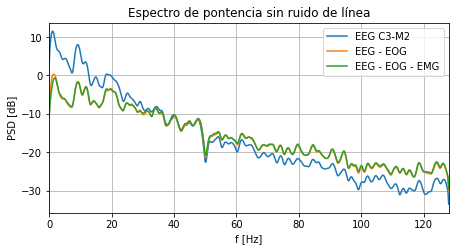

In [279]:
spectrum_plot_1([EEG, res1, res2], N0, title='Espectro de pontencia sin ruido de línea', fig_size=(7.16,3.5))

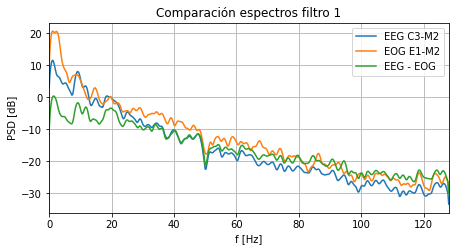

In [280]:
spectrum_plot_1([EEG, EOG, res1], N0, title='Comparación espectros filtro 1', fig_size=(7.16,3.5))

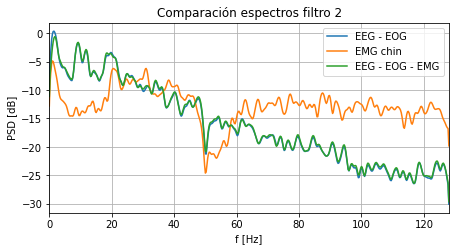

In [281]:
spectrum_plot_1([res1, EMG, res2], N0, title='Comparación espectros filtro 2', fig_size=(7.16,3.5))

In [76]:
def plot_w(w, M):
  figure, axes = plt.subplots(nrows=M, figsize=(15,10))
  for i in range(M):
    axes[i].plot(w[:,i])
  plt.show()

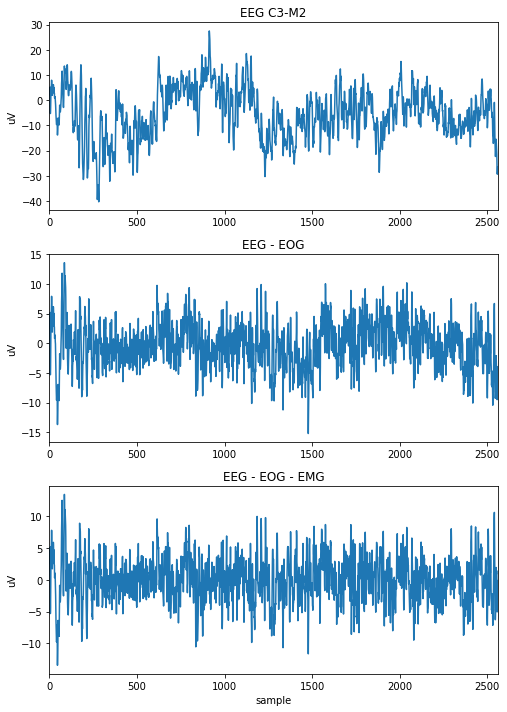

In [282]:
signal_plot([EEG, res1, res2], fig_size=(7.16,10))

# Análisis

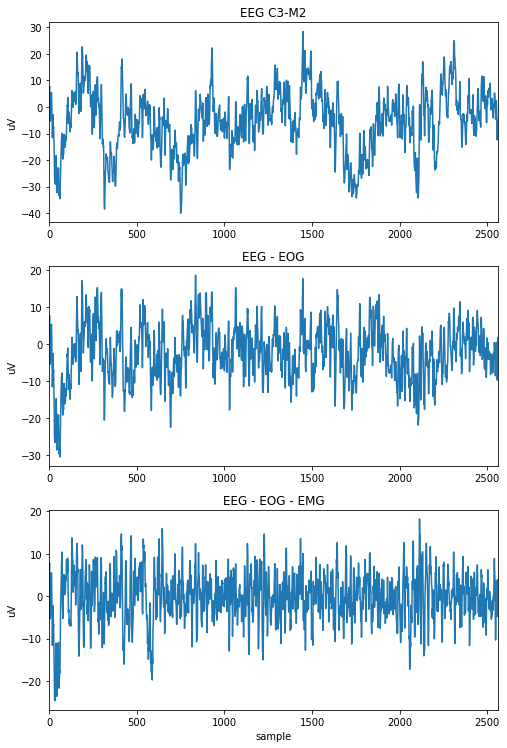

In [78]:
signal_plot([EEG, res1, res2], fig_size=(7.16,10.5))